## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch

from io import BytesIO
from random import randrange
from subprocess import call
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torchvision.transforms import RandomHorizontalFlip, ToTensor, Normalize
from urllib.request import urlopen, Request
from PIL import Image

## Hyperparameters

In [2]:
batch_size = 64
epochs = 10
learning_rate = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Train & Validation data

In [3]:
train_transf = transforms.Compose([RandomHorizontalFlip(), ToTensor(), Normalize((0.1307,), (0.3081,))])
val_transf = transforms.Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform = train_transf);
validation_set = datasets.MNIST(root='./data', train=False, download=True, transform=val_transf);

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=True)

## Dataset info

Train examples: 60000
Validation examples: 10000

Batch info
 Images: torch.Size([64, 1, 28, 28]) - Labels: torch.Size([64])


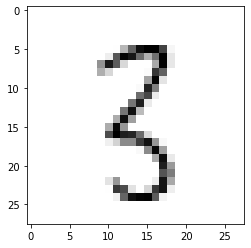

In [4]:
print(f'Train examples: {len(train_set)}\nValidation examples: {len(validation_set)}\n')

images, labels = iter(train_loader).next()

print(f'Batch info\n Images: {images.shape} - Labels: {labels.shape}')
plt.imshow(images[0][0,:,:], cmap='gray_r')

## Model

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4608, 2304)
        self.fc2 = nn.Linear(2304, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))        
        x = F.relu(self.conv2(x))
        
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Train function

In [6]:
def train(model, optimizer):    
    train_loss = 0    
    
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        data, target = data.to(device), target.to(device)        
        output = model(data)        
        loss = F.nll_loss(output, target)        
        loss.backward()        
        optimizer.step()
        
        train_loss += loss.item()    

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    torch.save(model.state_dict(), './checkpoints/handwritten_digit_classifier_model.pth')
    torch.save(optimizer.state_dict(), './checkpoints/handwritten_digit_classifier_optimizer.pth')
        
    print(f'Trained - Average loss: {train_loss:.4f}')        

## Validation function

In [7]:
def test(model):
    validation_loss = 0
    correct = 0
    
    model.eval()
    
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)            
            
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()            

    validation_loss /= len(validation_loader.dataset)
    validation_losses.append(validation_loss)    
    accuracy = correct * 100 / len(validation_loader.dataset)

    print(f'Validated - Average loss: {validation_loss:.4f} - Accuracy: {accuracy:.0f}%\n')

## Helper functions

In [8]:
def print_summary():
    print(f'Python: {sys.version}\n PyTorch: {torch.__version__}\n CUDNN: {torch.backends.cudnn.version()}')
    print(f'Device: {device} - Epochs: {epochs} - Initial learning rate: {learning_rate} - Batch size: {batch_size}\n')

In [9]:
def plot_losses():
    x = list(range(1, epochs + 1))
    
    plt.plot(x, train_losses, color='black')
    plt.plot(x, validation_losses, color='green')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.xlim(0, epochs)
    plt.ylim(0, max(max(train_losses), max(validation_losses)))
    
    plt.xticks(range(0, epochs))
    
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

In [10]:
def download_img(img_url):    
    req = Request(url=img_url, headers={'User-Agent': 'Mozilla/5.0'})
    res = urlopen(req)
    image = Image.open(BytesIO(res.read())).convert("L")
    image = image.resize((28, 28))
    return image

In [11]:
def display_web_img(image):
    arr = np.asarray(image)
    plt.imshow(arr, cmap='gray_r', vmin=0, vmax=255)
    plt.show()

In [12]:
def evaluate_web_image(model, image):
    image = (255 - np.expand_dims(np.array(image), -1))/255.0
    
    model.eval()
    
    with torch.no_grad():
        T = transforms.Compose([ToTensor()])
        output = model(torch.unsqueeze(T(image), axis=0).float().to(device))
        return F.softmax(output, dim=-1).cpu().numpy()

## Training

In [13]:
model = NeuralNetwork().to(device)

train_losses = []
validation_losses = []

optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=30)

print_summary()

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch:02d}/{epochs}')
    train(model, optimizer)
    test(model)
    scheduler.step()

Python: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
 PyTorch: 1.7.1
 CUDNN: 7605
Device: cuda - Epochs: 10 - Initial learning rate: 0.3 - Batch size: 64

Epoch 01/10
Trained - Average loss: 0.0042
Validated - Average loss: 0.0848 - Accuracy: 97%

Epoch 02/10
Trained - Average loss: 0.0014
Validated - Average loss: 0.0635 - Accuracy: 98%

Epoch 03/10
Trained - Average loss: 0.0010
Validated - Average loss: 0.0457 - Accuracy: 98%

Epoch 04/10
Trained - Average loss: 0.0008
Validated - Average loss: 0.0486 - Accuracy: 98%

Epoch 05/10
Trained - Average loss: 0.0006
Validated - Average loss: 0.0402 - Accuracy: 99%

Epoch 06/10
Trained - Average loss: 0.0006
Validated - Average loss: 0.0430 - Accuracy: 99%

Epoch 07/10
Trained - Average loss: 0.0005
Validated - Average loss: 0.0426 - Accuracy: 99%

Epoch 08/10
Trained - Average loss: 0.0004
Validated - Average loss: 0.0353 - Accuracy: 99%

Epoch 09/10
Trained - Average loss: 0.0004
Validated - Average loss: 0.0408 - Accuracy: 99%

E

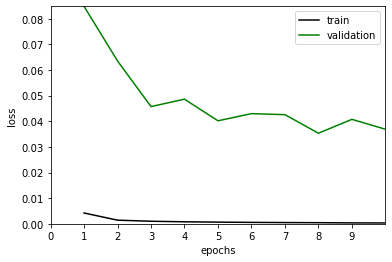

In [14]:
plot_losses()

## Evaluating example

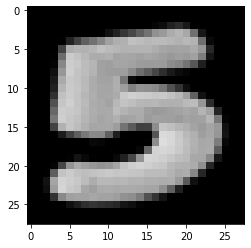

In [15]:
img_url = "https://st.depositphotos.com/1427101/3416/i/600/depositphotos_34164603-stock-photo-natural-grass-number-5.jpg"
image = download_img(img_url)
display_web_img(image)

In [16]:
pred = evaluate_web_image(model, image)
pred_idx = np.argmax(pred)

[print(f'{i}: {pred[0][i] * 100:.2f}%') for i in range(10)]
print(f'\nHighest prediction: {pred_idx} - Probability: {pred[0][pred_idx] * 100:.2f}%')

0: 5.05%
1: 5.49%
2: 11.70%
3: 6.73%
4: 3.47%
5: 45.94%
6: 4.93%
7: 4.46%
8: 5.05%
9: 7.18%

Highest prediction: 5 - Probability: 45.94%
